对4-8月内数据记录大于100条的生产者进行建模预测下一次的工作量
train(4-7月数据)
test(8月数据）
#对数据进行三天均值处理
#使用auto.arima，用个人历史工作量来预测未来下次的工作量
#只是对几个样本进行预测数据观测，没做循环所有样本

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [21]:
df = pd.read_csv('hashed_Salary_HC.csv', sep=',')
# df = df.iloc[:,1:]
df = df[['工作日期', '员工姓名#', '工序名称#', '应发工资']]
df.columns=['time','id','process','salary']
df['id'] = df['id'].map(lambda x: str(x)[1:])

# 按照日期筛选数据 4\5\6\7\8月
df = df[(df.time > '2020-03-31')&(df.time < '2020-09-01')]

# 将时间设置为index
df.set_index("time", inplace=True)
df.index = pd.DatetimeIndex(df.index)
print (df.head().append(df.tail()), df.describe(), df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16214 entries, 2020-04-02 to 2020-08-31
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       16214 non-null  object 
 1   process  16214 non-null  object 
 2   salary   16214 non-null  float64
dtypes: float64(1), object(2)
memory usage: 506.7+ KB
             id process  salary
time                           
2020-04-02   37   Type5   183.6
2020-04-02   36   Type4   362.1
2020-04-02    2   Type2   129.0
2020-04-02    2   Type2    80.0
2020-04-02   30   Type3    90.3
2020-08-31  107   Type5    36.0
2020-08-31  107   Type4    36.0
2020-08-31  107   Type5    40.5
2020-08-31  107   Type4    40.5
2020-08-31   55   Type3   187.5              salary
count  16214.000000
mean     161.969384
std      102.648396
min        0.500000
25%       79.200000
50%      148.000000
75%      222.020000
max      988.000000 None


In [3]:
# 这段日期里活跃的生产者名单
person = df['id'].unique()
print (person)

# 取出某个人的生产记录
person_data = df[df['id']==person[1]].groupby(['time'])['salary'].sum()
person_data = person_data.reset_index()
# index换成时间
person_data.set_index("time", inplace=True)
person_data.index = pd.DatetimeIndex(person_data.index)
person_data.head()

['37' '36' '2' '30' '39' '35' '10' '19' '34' '23' '28' '27' '31' '16' '38'
 '11' '12' '40' '33' '32' '41' '22' '42' '7' '43' '44' '45' '46' '47' '48'
 '49' '50' '51' '52' '53' '54' '55' '6' '56' '57' '58' '59' '60' '61' '62'
 '63' '64' '65' '66' '67' '68' '69' '70' '71' '72' '73' '74' '75' '76'
 '20' '77' '78' '79' '80' '81' '82' '83' '84' '85' '86' '87' '88' '89'
 '90' '91' '92' '93' '94' '95' '96' '97' '98' '99' '100' '101' '102' '18'
 '103' '104' '105' '106' '107' '108' '109']


,salary
time,
2020-04-02,362.1
2020-04-04,440.2
2020-04-05,869.5
2020-04-06,434.0
2020-04-07,802.3


In [4]:
allperson_data = {}
for i in range(len(person)):
    x = person[i]
    if len(df[df.id==x]) > 100: # 筛选数据条数至少大于100
        allperson_data[x] = df[df.id==x].iloc[:,-1]
    else:
        continue

print(allperson_data)

{'37': time
2020-04-02    183.60
2020-04-04    223.20
2020-04-05     48.40
2020-04-05    165.60
2020-04-05    238.50
               ...  
2020-08-28     75.00
2020-08-30     37.50
2020-08-30     43.50
2020-08-30    112.50
2020-08-31     84.25
Name: salary, Length: 259, dtype: float64, '36': time
2020-04-02    362.10
2020-04-04    440.20
2020-04-05     92.40
2020-04-05    326.60
2020-04-05    450.50
               ...  
2020-08-28     75.00
2020-08-30     37.50
2020-08-30     43.50
2020-08-30    112.50
2020-08-31    163.25
Name: salary, Length: 259, dtype: float64, '2': time
2020-04-02    129.00
2020-04-02     80.00
2020-04-02     80.00
2020-04-02     96.00
2020-04-02     72.00
               ...  
2020-08-30    156.00
2020-08-30     42.50
2020-08-30     17.00
2020-08-30     12.75
2020-08-31    187.50
Name: salary, Length: 1222, dtype: float64, '30': time
2020-04-02    90.3
2020-04-02    56.0
2020-04-02    48.0
2020-04-02    90.3
2020-04-02    67.2
              ... 
2020-04-26    12.6


In [33]:
personID = []
for key in allperson_data:
    personID.append(key)
print (personID)
train_data = allperson_data[personID[2]]   # 选择第3个人做预测
print (train_data)

['37', '36', '2', '30', '39', '35', '10', '19', '34', '23', '28', '16', '38', '11', '12', '32', '7', '44', '45', '46', '47', '49', '51', '52', '53', '55', '6', '56', '58', '61', '62', '63', '69', '70', '71', '72', '74', '76', '20', '77', '79', '81', '83', '84', '85', '87', '91', '101']
time
2020-04-02    129.00
2020-04-02     80.00
2020-04-02     80.00
2020-04-02     96.00
2020-04-02     72.00
               ...  
2020-08-30    156.00
2020-08-30     42.50
2020-08-30     17.00
2020-08-30     12.75
2020-08-31    187.50
Name: salary, Length: 1222, dtype: float64


In [42]:
a = train_data.resample('3D').mean()
b = train_data.resample('W-MON').mean()
print (a,b)
print (len(a),len(b))

time
2020-04-02    108.000000
2020-04-05    103.920000
2020-04-08    123.125000
2020-04-11    112.772727
2020-04-14     57.206897
2020-04-17     69.428571
2020-04-20    107.000000
2020-04-23    100.086957
2020-04-26     27.625000
2020-04-29     81.736842
2020-05-02     98.923077
2020-05-05     98.285714
2020-05-08     98.636364
2020-05-11    102.500000
2020-05-14     85.487805
2020-05-17     82.454545
2020-05-20     98.372093
2020-05-23    152.810811
2020-05-26    110.586207
2020-05-29    139.823529
2020-06-01    101.137931
2020-06-04     91.083333
2020-06-07    124.931818
2020-06-10    160.666667
2020-06-13    182.250000
2020-06-16    118.246154
2020-06-19     79.831250
2020-06-22    186.466667
2020-06-25    182.178125
2020-06-28     97.915625
2020-07-01    101.750000
2020-07-04    170.200000
2020-07-07    127.703226
2020-07-10    105.113333
2020-07-13     52.668750
2020-07-16    156.340000
2020-07-19     89.752941
2020-07-22    102.000000
2020-07-25     73.351429
2020-07-28     41.11

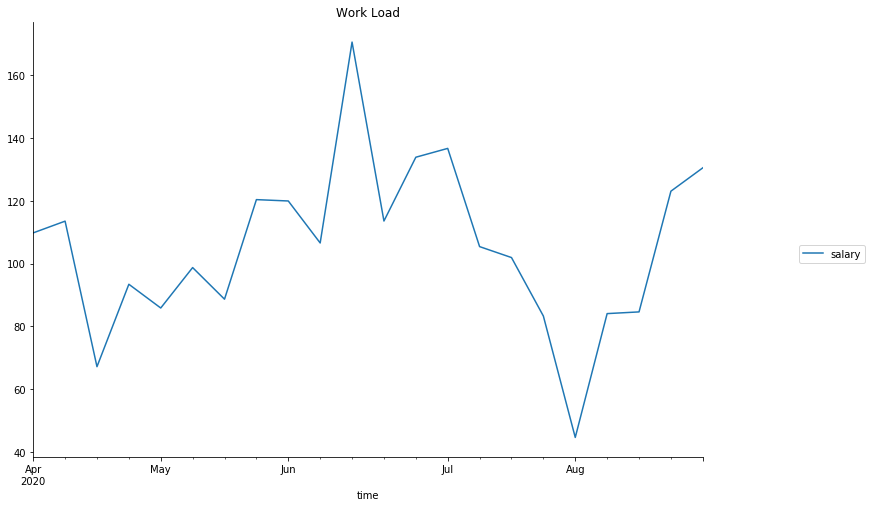

In [43]:
import seaborn as sns
b.plot(figsize=(12,8))

plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("Work Load")
sns.despine()

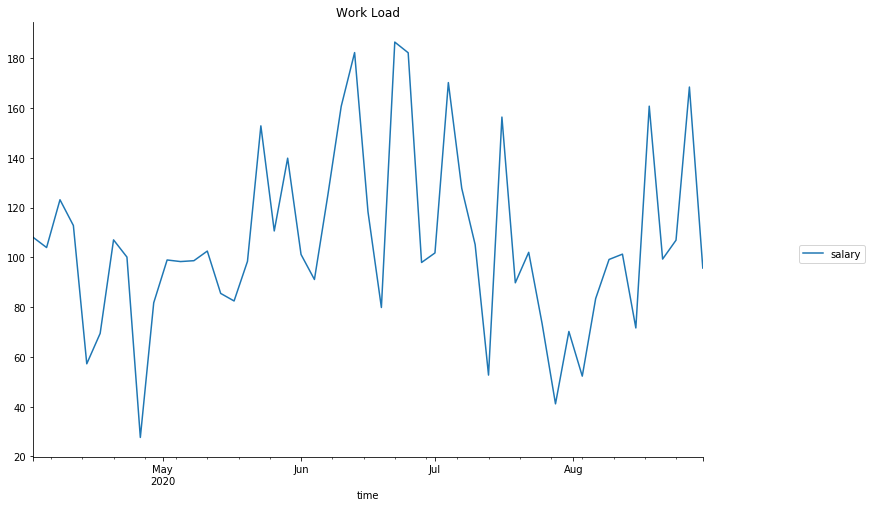

In [44]:
import seaborn as sns
a.plot(figsize=(12,8))

plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("Work Load")
sns.despine()

In [47]:
train = b[b.index<'2020-08']
test = b[b.index>'2020-08']
print (train,test)
print (len(train),len(test))

time
2020-04-06    109.750000
2020-04-13    113.481481
2020-04-20     67.160714
2020-04-27     93.393939
2020-05-04     85.836735
2020-05-11     98.705128
2020-05-18     88.643678
2020-05-25    120.333333
2020-06-01    119.902778
2020-06-08    106.538462
2020-06-15    170.475610
2020-06-22    113.522581
2020-06-29    133.827679
2020-07-06    136.638095
2020-07-13    105.377193
2020-07-20    101.894186
2020-07-27     83.278667
Freq: W-MON, Name: salary, dtype: float64 time
2020-08-03     44.642424
2020-08-10     84.054545
2020-08-17     84.595652
2020-08-24    123.020833
2020-08-31    130.450000
Freq: W-MON, Name: salary, dtype: float64
17 5


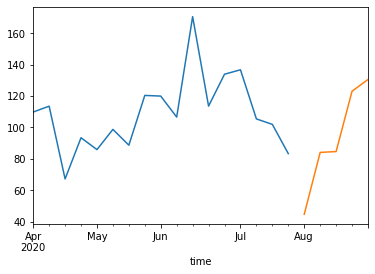

In [46]:
train.plot()
test.plot()

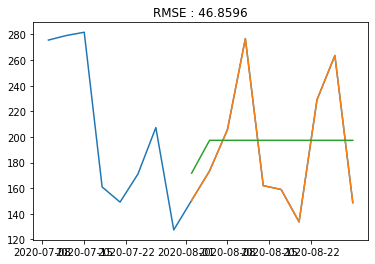

In [23]:
#building the model
import pmdarima as pm

model = pm.auto_arima(train)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index=test.index,columns=['Prediction'])
# 计算RMSE
rmse = np.sqrt(mean_squared_error(forecast, test))
#plot the predictions for validation set
plt.title('RMSE : %.4f' % rmse)
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(forecast,label='Prediction')
plt.show()

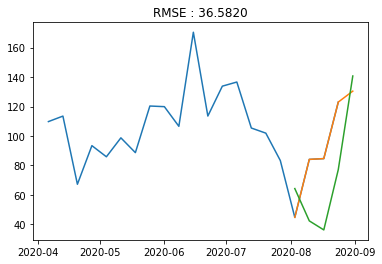

In [49]:
# 尝试滚动预测，每次预测t(n+1)，并且把实际发生的t(n+1)加入模型训练预测t(n+2)
from sklearn.metrics import mean_squared_error
pre = []
for i in range(len(test)):
    train = b[0:(17+i)]
    
    
    #building the model
    model = pm.auto_arima(train, start_p=0, start_q=0, max_p=6, max_q=6, max_d=2,
                           seasonal=False, test='adf',
                           error_action='ignore',
                           information_criterion='aic',
                           njob=-1, suppress_warnings=True)
    model.fit(train)
    forecast = model.predict(n_periods=1)
    pre.append(forecast[-1])

predictions_ = pd.Series(pre,index=test.index)
# 计算RMSE
rmse = np.sqrt(mean_squared_error(predictions_, test))
#plot the predictions for validation set
plt.title('RMSE : %.4f' % rmse)
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(predictions_,label='Prediction')
plt.show()
    